# Measuring Galaxy Shapes

***

## Kernel Information and Read-Only Status

To run this notebook, please select the "Roman Calibration" kernel at the top right of your window.

This notebook is read-only. You can run cells and make edits, but you must save changes to a different location. We recommend saving the notebook within your home directory, or to a new folder within your home (e.g. <span style="font-variant:small-caps;">file > save notebook as > my-nbs/nb.ipynb</span>). Note that a directory must exist before you attempt to add a notebook to it.

## Imports
Below we list the libraries we'll be using in the tutorial:
- *astropy.coordinates* to perform sky-to-detector coordinate transformations
- *astropy.stats* to estimate the sky background level
- *astropy.table* for manipulating tabular data
- *astropy.units* for working with units
- *astropy.visualization* for normalizing images for plotting
- *coord* for working with angles
- *matplotlib.pyplot* for plotting and visualizing data
- *galsim* to measure source moments and generate Sérsic profiles
- *numpy* for array manipulation and mathematical operations
- *roman_datamodels* for opening WFI ASDF files
- *asdf* for opening WFI ASDF files
- *s3fs* for streaming simulated WFI images from an S3 bucket
- *scipy.optimize* to fit our data
- *synphot* for synthetic photometry
- *stsynphot* to access WFI throughput information
- *stpsf* to access WFI point spread functions

In [1]:
from astropy.coordinates import SkyCoord
from astropy.stats import sigma_clipped_stats
from astropy.table import Table
import astropy.units as u
from astropy.visualization import simple_norm
import coord
import matplotlib.pyplot as plt
import galsim
from galsim.roman import collecting_area
import numpy as np
import roman_datamodels as rdm
import asdf
import s3fs
from scipy.optimize import curve_fit
import synphot as syn
import stsynphot as stsyn
import stpsf

%matplotlib inline

## Introduction
The main goal of this notebook is to illustrate a typical use case of Roman images: performing shape measurements of astronomical sources. 

We are going to perform two sets of measurements. First, we rely on [GalSim](https://galsim-developers.github.io/) to perform ellipticity measurements. In particular, we use the
[REGAUSS method in its HSM module](https://galsim-developers.github.io/GalSim/_build/html/hsm.html) ([Hirata & Seljak 2003](https://ui.adsabs.harvard.edu/abs/2003MNRAS.343..459H/abstract), [Mandelbaum et al. 2005](https://ui.adsabs.harvard.edu/abs/2005MNRAS.361.1287M/abstract)). Second, we fit a Sérsic model to a galaxy cutout.

In this notebook, we will be building on previous tutorials. We recommend consulting the following tutorials prior to this one:
- Data Access and Discovery
- Working with ASDF
- Data Visualization
- STPSF
- Synphot

### Defining Terms

- ASDF: Advanced Scientific Data Format — the data format for the Roman Wide Field Instrument

***

## Loading Data
The first step of the analysis is to read the Roman WFI image data, which are stored in ASDF format. For this example, we start with a calibrated Level 2 (L2) simulated image created with [Roman I-Sim](https://romanisim.readthedocs.io). For more information about Roman's data products check the [Roman User Documentation](roman-docs.stsci.edu). We use `roman_datamodels` to open the simulated image, which we stream into memory from an S3 bucket:

In [2]:
# Open an image from an S3 bucket
asdf_dir_uri = 's3://stpubdata/roman/nexus/soc_simulations/tutorial_data/'
fs = s3fs.S3FileSystem(anon=True)
asdf_file_uri_l2 = asdf_dir_uri + 'r0003201001001001004_0001_wfi01_f106_cal.asdf'
    
file = rdm.open(fs.open(asdf_file_uri_l2, 'rb'))

To characterize the shape of our sources, we need to get cutouts of individual targets, and perform our measurements. We choose to use the input catalog from the simulation software to define our cutouts. In a more realistic scenario, we would run a source detection algorithm to identify the locations of the sources.

We start by saving the image array in the `image` variable. Remember that the `.data` datablock in WFI ASDF files contains the data array, and this is an `numpy.ndarray` object with values of data numbers (DN) per second (DN/s).

In [3]:
# Get the data array as an numpy.ndarray object
image = file.data

We read the input catalog using `astropy.table.Table()`. More details about the format of these catalogs are available [here](https://romanisim.readthedocs.io/en/latest/romanisim/catalog.html).

In [4]:
# Open the catalog used for the simulation as an astropy.table.Table
cat_uri = asdf_dir_uri + 'full_catalog.ecsv'
catalog = Table.read(fs.open(cat_uri, 'rb'), format='ascii.ecsv')

As a quick sanity check we plot the positions of 1% of the objects:

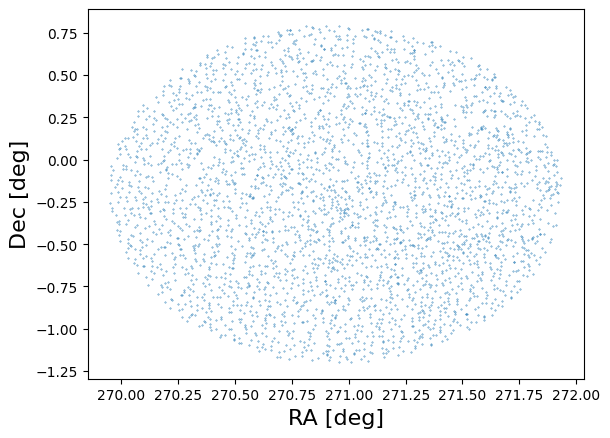

In [5]:
# Make a scatter plot of the positions of a subselection of catalog entries.
plt.scatter(catalog['ra'][::100], catalog['dec'][::100], s=0.1)
plt.xlabel('RA [deg]', fontsize=16)
plt.ylabel('Dec [deg]', fontsize=16);

## Creating Cutouts and Retrieving the PSF

The positions are in sky coordinates. In order to make the cutouts we need the pixel coordinates in the image. To do that transformation, we will use the generalized World Coordinate System (GWCS) object in the simulated file's metadata.
For more information about GWCS please check the documentation [here](https://gwcs.readthedocs.io/).

In [6]:
# Save the gwcs object from the ASDF file into a variable
wcs = file.meta.wcs 

Next, we use the GWCS object to transform from the catalog right ascension (RA) and declination (DEC) coordinates into pixel positions within the image:

In [7]:
# Save the catalog coordinates in a SkyCoord object and 
# convert to pixel positions.
coords = SkyCoord(ra=catalog['ra'] * u.deg, dec=catalog['dec'] * u.deg)
x, y = wcs.world_to_pixel(coords)

# Save the x and y coordinates in the catalog table for later.
catalog['x'] = x
catalog['y'] = y

For illustrative purposes, we focus on relatively bright ($18 < {m}_\mathrm{AB} < 19$) galaxies (marked as type = SER in the catalog). First, we need to know the optical element used for the observation, which we can get from the file metadata:

In [8]:
band = file.meta.instrument.optical_element
print(f'The simulated bandpass is {band}')

The simulated bandpass is F106


Now let's trim our catalog based on our magnitude cuts and selection of extended sources:

In [9]:
# Set magnitude limits.
mag_hi = 19
mag_lo = 18

# Compute the AB magnitude of the F106 filter in the catalog.
mag_ab = -2.5 * np.log10(catalog['F106'])

# Select sources within our magnitude limits and that are extended.
bright = (mag_ab > mag_lo) & (mag_ab < mag_hi) & (catalog['type'] == 'SER')

# The input catalog may contain sources that are not on the WFI detector.
# Identify where sources are on the detector. The padding variable will
# ensure that sources are not too close to the edge (and possibly cut off).
padding = 10
inchip = (x > padding) & (x < image.shape[0] - padding) & (y > padding) & (y < image.shape[1] - padding)

# Our final selection is the intersection of these two lists of indices.
# The variable gal_tab contains a subselection of the original catalog
# that meets our selection criteria.
galaxies = (bright) & (inchip)
gal_tab = catalog[galaxies]

print(np.count_nonzero(galaxies), 'galaxies pass these selection criteria')

9 galaxies pass these selection criteria


Most morphological measurements require high-accuracy knowledge of the PSF. In the case of our simulated scene, we know that the PSF was generated via `stpsf`. For simplicity, we will be working with a single PSF, but users interested in high accuracy fits will likely want to generate a PSF at the pixel location of each of the sources being fit. See the [STPSF tutorial](../stpsf/stpsf.ipynb) tutorial for more information.

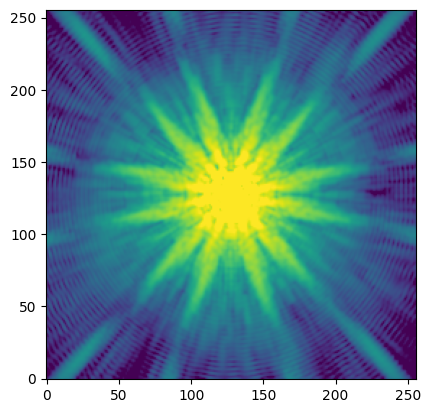

In [10]:
# Set up the WFI instrument object in STPSF, set the optical element, and generate a PSF.
wfi = stpsf.WFI()
wfi.filter = band
psf = wfi.calc_psf(fov_pixels=64)

# Generate a galsim image object of the simulated PSF. We specify the pixel scale for which
# the WFI has 0.11 arcsecond pixels, and the PSF from STPSF is oversampled by a factor of 4.
# Save the PSF as an interpolated image so we can convolve and deconvolve later on.
psf_img = galsim.Image(psf['OVERSAMP'].data, scale=0.11 / 4)
psf_obj = galsim.InterpolatedImage(psf_img, flux=1)  

# Show the simulated PSF.
plt.imshow(psf_img.array, norm=simple_norm(psf_img.array, 'log', percent=95), origin='lower');

By default the PSF is generated for detector WFI01 at (x, y) = (2048, 2048) in the science coordinate system. See the [RDox article on WFI coordinate systems]( https://roman-docs.stsci.edu/data-handbook-home/wfi-data-format/coordinate-systems) for more information.

These attributes can be confirmed and modified via the `wfi.detector` and `wfi.detector_position` attributes.

In [11]:
print(f'STPSF detector = {wfi.detector}')
print(f'STPSF position = {wfi.detector_position}')

STPSF detector = WFI01
STPSF position = (2048, 2048)


Now, before creating a cutout, we need to estimate the sky background level, since the WFI L2 images are not background subtracted. For our example we'll use the sigma-clipped median of the image. While this background estimate is simplistic, it is effective for our purpose.

In [12]:
# Compute the sigma-clipped median as an estimate of the sky background
_, med_bkg, _ = sigma_clipped_stats(image)
print(f'Median background = {med_bkg:0.5f} DN / s')

Median background = 0.66544 DN / s


Now let's create a cutout of our galaxy by creating a small postage stamp centered on the x and y coordinates we previously computed from the input simulation catalog. We will adapt the size of the postage stamp to the half-light radius of the galaxy from the input simulation catalog.

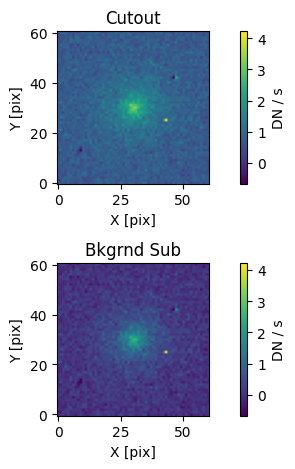

In [13]:
# Create a variable to index our table of galaxies. Changing this variable will
# change the galaxy that we are fitting.
igal = 2

# Get the dimensions of cutout based on the half-light radius. The scale variable
# will set the multiples of the half-light radius used for the cutout. 
scale = 4

# Multiply the half-light radius in arcseconds by the scale factor, and then
# divide by the pixel scale of 0.11 arcseconds per pixel to get the half-light
# radius in units of pixels. Add 1 pixel for padding so that small galaxies have
# a sufficiently sized cutout.
size = int((gal_tab['half_light_radius'][igal] * 4 / 0.11) + 1)

# Determine the x and y positions at the corners of our cutout.
xmin = int(gal_tab['x'][igal] - size//2)
xmax = xmin + size + 1
ymin = int(gal_tab['y'][igal] - size//2)
ymax = ymin + size + 1

# Make the cutout as a galsim Image object. Also subtract the sky background estimate,
# and set the pixel scale.
cutout = galsim.Image(image[ymin:ymax, xmin:xmax] - med_bkg, scale=0.11)

# Display the cutout with and without the background subtraction.
# Set the image normalization. To compare the cutout before and after
# background subtraction, we manually set the limits.
norm = simple_norm(cutout.array + med_bkg, 'linear', vmin= -med_bkg, vmax=np.max(cutout.array))

# Setup the plot area.
fig, axs = plt.subplots(2, 1)

# Original cutout (add the sky background back in)
cut = axs[0].imshow(cutout.array + med_bkg, origin='lower', norm=norm)
axs[0].set_title('Cutout')
axs[0].set_xlabel('X [pix]')
axs[0].set_ylabel('Y [pix]')

# Background-subtracted cutout
bkg_cut = axs[1].imshow(cutout.array, origin='lower', norm=norm)
axs[1].set_title('Bkgrnd Sub')
axs[1].set_xlabel('X [pix]')
axs[1].set_ylabel('Y [pix]')

# Assign color bars. The color bars and normalization are the same
# for both cutouts.
fig.colorbar(cut, ax=axs[0], label='DN / s')
fig.colorbar(bkg_cut, ax=axs[1], label='DN / s')
plt.tight_layout(h_pad=1);

As we can see, the background estimate seems to be reasonable. We could improve it by performing a local background estimate rather than using the whole image. For on-orbit observations, a 2-D local background model would likely provide the highest fidelity background estimate. Note that estimating the background should be treated with care, since it will affect the fitting results. 

## Estimating the Source Moments

Now that we have our cutout saved as a `galsim.Image` object we can just use the `hsm` module to estimate the moments:

In [14]:
shape = galsim.hsm.FindAdaptiveMom(cutout, strict=False)
shape

galsim.hsm.ShapeData(image_bounds=galsim.BoundsI(xmin=1, xmax=61, ymin=1, ymax=61), moments_status=0, observed_shape=galsim.Shear((0.030699152091217177-0.039635425291356316j)), moments_sigma=8.121443748474121, moments_amp=539.923583984375, moments_centroid=galsim.PositionD(x=31.24049386502952, y=30.782722435327653), moments_rho4=2.3635924134158204, moments_n_iter=20)

The `shape` variable contains the source moments estimated from the best-fit elliptical Gaussian. For example, we can see in the printed result that the `.observed_shape` attribute contains a `galsim.Shear` object. From that object, we can retrieve shape parameters such as the position angle (beta) and the minor-to-major axis ratio (q):

In [15]:
# Get the position angle (beta) and wrap it to the range [0, 2pi) radians and convert to degrees
beta = shape.observed_shape.beta.wrap(center = 180 * coord.degrees).deg

# Get the minor-to-major axis ratio (q)
q = shape.observed_shape.q

print(f'position angle: {beta:.5f} deg')
print(f'minor-to-major axis ratio: {q:.5f}')

position angle: 333.87958 deg
minor-to-major axis ratio: 0.90452


Since we have the PSF model we can also try to estimate the PSF-corrected galaxy shear:

In [16]:
shape2 = galsim.hsm.EstimateShear(cutout, psf_img, strict=False)
shape2

galsim.hsm.ShapeData(image_bounds=galsim.BoundsI(xmin=1, xmax=61, ymin=1, ymax=61), moments_status=0, observed_shape=galsim.Shear((0.030699152091217177-0.039635425291356316j)), moments_sigma=7.47904634475708, moments_amp=638.07958984375, moments_rho4=2.3635924134158204, moments_n_iter=20, correction_status=0, corrected_e1=0.08097836375236511, corrected_e2=-0.06341058015823364, meas_type='e', corrected_shape_err=0.0, correction_method='REGAUSS', resolution_factor=0.9663776159286499, psf_sigma=1.3743653297424316, psf_shape=galsim.Shear((-0.014325833994391213+0.0008789983818878098j)))

We can once again extract information about the position angle and minor-to-major axis ratio as we did before:

In [17]:
beta = shape2.observed_shape.beta.wrap(center = 180 * coord.degrees).deg
q = shape2.observed_shape.q
print(f'position angle: {beta:.5f} deg')
print(f'minor-to-major axis ratio: {q:.5f}')

position angle: 333.87958 deg
minor-to-major axis ratio: 0.90452


In this case, we see that the values are the same with and without the PSF-correction.

## Fitting a Sérsic Profile to a Source

Another typical morphological analysis consists of fitting a source with a [Sérsic profile](https://en.wikipedia.org/wiki/S%C3%A9rsic_profile) ([Sérsic 1963](https://ui.adsabs.harvard.edu/abs/1963BAAA....6...41S/abstract)). We are going to rely on the Sérsic implementation in the `galsim` package.

In our example we will ignore the pixel mask (data quality array), but will use the error image.

First, we need to convert our source flux units to photons / s / cm$^2$. The catalog fluxes are stored as maggies, which are linear flux units such that:

$m_\mathrm{AB} = -2.5\times\log_{10}(f),$ 

where $m_\mathrm{AB}$ is the AB magnitude and $f$ is the flux in maggies. As Roman I-Sim, which was used to generate the catalog and simulate the image, does not create sources with realistic colors, let's make a simplifying assumption that our source has a spectral energy distribution (SED) that is flat in frequency space, at least over the bandpass of interest (F106). We will use the `synphot` package to synthetically observe the source spectrum, normalized to the AB magnitude from the catalog, and integrate over the bandpass:

In [18]:
# Compute the AB magnitude of the source.
abmag = -2.5 * np.log10(gal_tab['F106'][igal])

# Create the spectrum and bandpass objects, and then observe the spectrum
# through the bandpass.
spec = syn.SourceSpectrum(syn.models.ConstFlux1D, amplitude=abmag * u.ABmag)
band = stsyn.band('roman,wfi,f106')
obs = syn.Observation(spec, band)

# Integrate over the bandpass. By default, calls to the obs variable, which
# stores a synphot Observation object, will return units of photlam, which
# is shorthand for photons / s / cm^2 / Angstrom. The binset attribute contains
# the default wavelengths used in the Observation object, which have units of
# Angstroms. Thus, the integral of the Observation over the wavelengths will
# give units of photons / s / cm^2.
waves = obs.binset
flux = np.trapezoid(obs(waves), x=waves).value

print(f'Source flux: {flux:.5f} photon / s / cm^2')

Source flux: 0.04214 photon / s / cm^2

Note that we could have instead determined a scaling factor to apply to any input flux from the catalog by normalizing the spectrum to an amplitude of 1 maggie. Synphot does not allow us to use the `astropy.units.maggy` unit, but we can just as effectively use the definition of AB magnitudes to write this in units of Jankys:

$m_\mathrm{AB} = -2.5 \times log_{10}(f_\mathrm{Jy}) + 8.90,$

and thus when $m_\mathrm{AB} = 0$ mag, which is defined when $f = 1$ maggie, we find that $f_\mathrm{Jy} = 10^{(8.90 / 2.5)} \approx 3630.78055~\mathrm{Jy}$. Determining such a scaling factor would be useful if we wanted to perform our shape analysis at scale.

Then we create our model as a callable function for later fitting. The variables are:
* n = Sérsic index
* hlr = half-light radius in arcseconds
* pa = position angle in degrees
* x0 = shift in x pixels to center of the source
* y0 = shift in y pixels to center of the source
* q = minor-to-major axis ratio

We will set the gain and area options in the `drawImage()` method on the `galsim.Sersic` object we create. This ensures that the model of our galaxy can return pixels with values like our observed image that has units of DN / s. We set the gain to 1.8, which is a reasonable value for a general WFI detector, and we use the obscured collecting area from the `galsim.roman` module.

In [19]:
def sersic_mod(cutout, n, hlr, influx, pa, x0, y0, q):
    nx, ny = cutout.array.shape
    ser = galsim.Sersic(n, half_light_radius=hlr, flux=influx)
    ser = ser.shear(q=q, beta=pa * galsim.degrees)  # change PA and axis ratio
    offset = galsim.PositionD(x=x0, y=y0)  # potentially shift a bit the profile
    ser = galsim.convolve.Convolve(ser, psf_obj)  # add PSF
    img = galsim.ImageD(nx, ny, scale=0.11)  
    ser.drawImage(image=img, offset=offset, scale=0.11, gain=1.8, area=galsim.roman.collecting_area)
    
    return img.array.flatten()

Next, we initialize the model with the truth parameters. The Sérsic index, half-light radius, position angle, and minor-to-major axis ratio come from the input simulation catalog. The flux is the value computed above in the correct units of photons / s / cm$^2$. The x0 and y0 shifts are assumed to both be 0.0.

In [20]:
# Create a list of the truth paramters.
p0 = [gal_tab['n'][igal], gal_tab['half_light_radius'][igal], flux, gal_tab['pa'][igal], 0., 0., gal_tab['ba'][igal]]

# Create the model with our truth parameters
fid_model = sersic_mod(cutout, *p0)

Notice that we used the syntax `*p0` above. This is the same as explicitly writing out `p0[0], p0[1], ..., p0[6]` and is a convenient way in Python to unpack all of the values in a list in order as inputs to a function's positional arguments.

We also obtain the error array in the location of the cutout:

In [21]:
err_img = file.err[ymin:ymax, xmin:xmax].flatten()

Next, we fit the model using `scipy.curve_fit()`. We add bounds to the parameter space in order avoid software issues and unphysical values — GalSim only supports $0.3 < n < 6.2$.

**NOTE:** If the following code cell produces an exception, you may have to adjust the bounds of the fit. This can happen, for example, if you changed any of the filtering we did above on the source catalog (e.g., a different magnitude range cut).

In [22]:
pout, pcov = curve_fit(sersic_mod, cutout, cutout.array.flatten(), sigma=err_img,
          p0=p0, bounds=([0.3, 0.01, 1e-11, 0, -size/2, -size/2, 0], [6.2, 4.0, 0.1, 360, size/2, size/2, 1]))

Let's see the resulting best-fit parameters of the fit and compare to our initial input model parameters (the `p0` variable above):

In [23]:
labels = ('n', 'hlr', 'flux', 'pa', 'x0', 'y0', 'q')

for i, _ in enumerate(p0):
    print(f'{labels[i]}:')
    print(f'\tInitial: {p0[i]:.5f}')
    print(f'\tFitted: {pout[i]:.5f}')

n:
	Initial: 1.61296
	Fitted: 1.59112
hlr:
	Initial: 1.63962
	Fitted: 1.61616
flux:
	Initial: 0.04214
	Fitted: 0.04006
pa:
	Initial: 303.75232
	Fitted: 360.00000
x0:
	Initial: 0.00000
	Fitted: 0.28059
y0:
	Initial: 0.00000
	Fitted: -0.00547
q:
	Initial: 0.93859
	Fitted: 0.94755


Comparing the input and best-fit parameters, we see good agreement.

Let's create an image of our best-fit model and visualize the original cutout, initial input model, best-fit output model, and fit residuals:

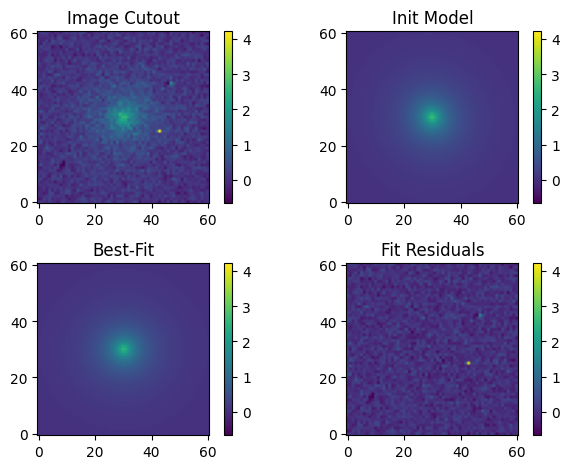

In [24]:
# Make an image of the best-fit model and compute the fit residuals.
model_out = sersic_mod(cutout, *pout)
residual = cutout.array - model_out.reshape(cutout.array.shape)

# Plot the original cutout, initial input model, best-fit model, and fit residuals.
# Plot all images with the same normalization for comparison. As we may have negative
# residual values, we use a linear normalization.
norm = simple_norm(cutout.array, 'linear', vmin= -med_bkg, vmax=np.max(cutout.array))

fig, axs = plt.subplots(2, 2)
# Original image
orig = axs[0][0].imshow(cutout.array, norm=norm, origin='lower')
axs[0][0].set_title('Image Cutout')

# Fiducial (initial input) model
axs[0][1].imshow(fid_model.reshape(cutout.array.shape), norm=norm, origin='lower')
axs[0][1].set_title('Init Model')

# Best-fitting model
axs[1][0].imshow(model_out.reshape(cutout.array.shape), norm=norm, origin='lower')
axs[1][0].set_title('Best-Fit')

# Fit residuals
axs[1][1].imshow(residual, norm=norm, origin='lower')
axs[1][1].set_title('Fit Residuals')

# Set the colorbar
fig.colorbar(orig, ax=axs[0][0])
fig.colorbar(orig, ax=axs[0][1])
fig.colorbar(orig, ax=axs[1][0])
fig.colorbar(orig, ax=axs[1][1])

# Other plot settings to clean it up.
plt.tight_layout(h_pad=1);

Our fit looks really good. Let's take a quick look at the statistics of the fit residuals:

In [25]:
print(f'Residual median: {np.median(residual):.5f} DN / s')
print(f'Residual std dev: {np.std(residual):.5f} DN / s')

Residual median: 0.00849 DN / s
Residual std dev: 1.19272 DN / s


We benefitted greatly from knowing a lot of these parameters from the simulated input catalog used to generate the image. What if we didn't know these values so well? Would we have gotten such a good fit result? Let's test that now by setting the fiducial model to something less certain and fit it again. 

We'll set our `p1` variable to contain our new input parameters. Recall the input parameter order is Sérsic index, half-light radius in arcseconds, flux in photons / s / cm$^2$, position angle in degrees, x shift, y shift, and minor-to-major axis ratio. Let's assume we can measure the flux well, and that we estimate the half-light radius to be approximately 4 WFI pixels, or 0.44 arcseconds. We'll set the other values to uninformed guesses.

In [26]:
p1 = [1., 0.44, flux, 0., 0., 0., 0.5]

# Create the model with our truth parameters
fid_model_new = sersic_mod(cutout, *p1)

pout_new, pcov_new = curve_fit(sersic_mod, cutout, cutout.array.flatten(), sigma=err_img,
          p0=p1, bounds=([0.3, 0.01, 1e-11, 0, -size/2, -size/2, 0], [6.2, 4.0, 0.1, 360, size/2, size/2, 1]))

labels = ('n', 'hlr', 'flux', 'pa', 'x0', 'y0', 'q')

for i, _ in enumerate(p0):
    print(f'{labels[i]}:')
    print(f'\tCatalog (p0): {p0[i]:.5f}')
    print(f'\tNew inputs (p1): {p1[i]:.5f}')
    print('')
    print(f'\tOld fit: {pout[i]:.5f}')
    print(f'\tNew fit: {pout_new[i]:.5f}')

n:
	Catalog (p0): 1.61296
	New inputs (p1): 1.00000

	Old fit: 1.59112
	New fit: 1.58818
hlr:
	Catalog (p0): 1.63962
	New inputs (p1): 0.44000

	Old fit: 1.61616
	New fit: 1.61339
flux:
	Catalog (p0): 0.04214
	New inputs (p1): 0.04214

	Old fit: 0.04006
	New fit: 0.04003
pa:
	Catalog (p0): 303.75232
	New inputs (p1): 0.00000

	Old fit: 360.00000
	New fit: 28.20436
x0:
	Catalog (p0): 0.00000
	New inputs (p1): 0.00000

	Old fit: 0.28059
	New fit: 0.28433
y0:
	Catalog (p0): 0.00000
	New inputs (p1): 0.00000

	Old fit: -0.00547
	New fit: -0.00446
q:
	Catalog (p0): 0.93859
	New inputs (p1): 0.50000

	Old fit: 0.94755
	New fit: 0.90761


As we can see, the best-fitting model is quite similar to the previous one with the exceptions of the flux, minor-to-major axis ratio, and the position angle. In fact, on closer examination, we can see that the position angle and minor-to-major axis ratio in our earlier fit is identical to the input values we obtained from the catalog.

Let's try again, but this time let's use the shear estimate shape measurements we previously performed (recall that beta and q are the position angle and minor-to-major axis ratio, respectively, from the PSF-corrected shear estimate in the `shape2` variable above): 

In [27]:
p1 = [1., 0.44, flux, beta, 0., 0., q]

# Create the model with our truth parameters
fid_model_new = sersic_mod(cutout, *p1)

pout_new, pcov_new = curve_fit(sersic_mod, cutout, cutout.array.flatten(), sigma=err_img,
          p0=p1, bounds=([0.3, 0.01, 1e-11, 0, -size/2, -size/2, 0], [6.2, 4.0, 0.1, 360, size/2, size/2, 1]))

labels = ('n', 'hlr', 'flux', 'pa', 'x0', 'y0', 'q')

for i, _ in enumerate(p0):
    print(f'{labels[i]}:')
    print(f'\tCatalog (p0): {p0[i]:.5f}')
    print(f'\tNew inputs (p1): {p1[i]:.5f}')
    print('')
    print(f'\tOld fit: {pout[i]:.5f}')
    print(f'\tNew fit: {pout_new[i]:.5f}')

n:
	Catalog (p0): 1.61296
	New inputs (p1): 1.00000

	Old fit: 1.59112
	New fit: 1.59121
hlr:
	Catalog (p0): 1.63962
	New inputs (p1): 0.44000

	Old fit: 1.61616
	New fit: 1.61624
flux:
	Catalog (p0): 0.04214
	New inputs (p1): 0.04214

	Old fit: 0.04006
	New fit: 0.04006
pa:
	Catalog (p0): 303.75232
	New inputs (p1): 333.87958

	Old fit: 360.00000
	New fit: 360.00000
x0:
	Catalog (p0): 0.00000
	New inputs (p1): 0.00000

	Old fit: 0.28059
	New fit: 0.28060
y0:
	Catalog (p0): 0.00000
	New inputs (p1): 0.00000

	Old fit: -0.00547
	New fit: -0.00542
q:
	Catalog (p0): 0.93859
	New inputs (p1): 0.90452

	Old fit: 0.94755
	New fit: 0.94750


Much better! Now the best-fit flux agrees well with the catalog value. We also see that we got similar values of the other best-fit parameters other than the position angle and minor-to-major axis ratio. It seems that these two parameters are not well constrained by the data using the Sérsic model fit.

For completeness, let's also re-plot the cutout, models, and fit residuals with out new inputs and best fit:

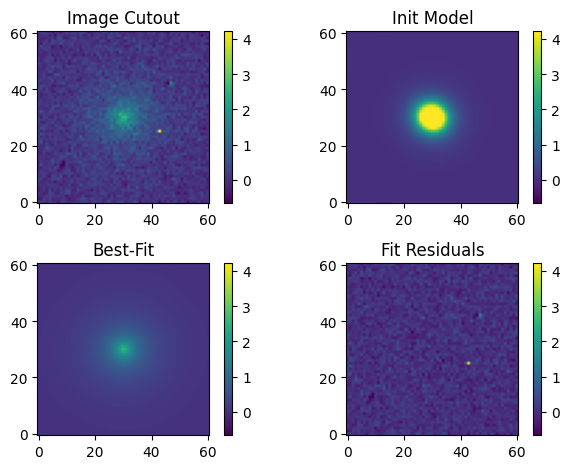

In [28]:
# Make an image of the best-fit model and compute the fit residuals.
model_out_new = sersic_mod(cutout, *pout_new)
residual_new = cutout.array - model_out_new.reshape(cutout.array.shape)

# Plot the original cutout, initial input model, best-fit model, and fit residuals.
# Plot all images with the same normalization for comparison. As we may have negative
# residual values, we use a linear normalization.
norm = simple_norm(cutout.array, 'linear', vmin= -med_bkg, vmax=np.max(cutout.array))

fig, axs = plt.subplots(2, 2)
# Original image
orig = axs[0][0].imshow(cutout.array, norm=norm, origin='lower')
axs[0][0].set_title('Image Cutout')

# Fiducial (initial input) model
axs[0][1].imshow(fid_model_new.reshape(cutout.array.shape), norm=norm, origin='lower')
axs[0][1].set_title('Init Model')

# Best-fitting model
axs[1][0].imshow(model_out_new.reshape(cutout.array.shape), norm=norm, origin='lower')
axs[1][0].set_title('Best-Fit')

# Fit residuals
axs[1][1].imshow(residual_new, norm=norm, origin='lower')
axs[1][1].set_title('Fit Residuals')

# Set the colorbar
fig.colorbar(orig, ax=axs[0][0])
fig.colorbar(orig, ax=axs[0][1])
fig.colorbar(orig, ax=axs[1][0])
fig.colorbar(orig, ax=axs[1][1])

# Other plot settings to clean it up.
plt.tight_layout(h_pad=1);

As we can see, the initial model is quite different from our previous one based on inputs from the catalog, but our best-fit model and residuals still look quite good. Finally, the statistics of our residuals:

In [29]:
print(f'Residual median: {np.median(residual_new):.5f} DN / s')
print(f'Residual std dev: {np.std(residual_new):.5f} DN / s')

Residual median: 0.00848 DN / s
Residual std dev: 1.19272 DN / s


Comparing these values with our earlier fit, we find that the median and standard deviation of the residuals of both fits are identical to within four decimal places despite differences in the input and best-fit model parameters.

From `scipy.optimize.curve_fit()`, we also have the estimated approximate covariance information for each of the fitted parameters. From the `scipy` [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html), we can use that information to compute the 1-$\sigma$ uncertainties on the fitted parameters:

In [30]:
perr = np.sqrt(np.diag(pcov))

where `pcov` is the covariance of the fit (recall that `pout` is the fitted values above). Now we can print the fitted values with the uncertainties:

In [31]:
labels = ('n', 'hlr', 'flux', 'pa', 'x0', 'y0', 'q')

for i, _ in enumerate(p0):
    print(f'{labels[i]} = {pout[i]:.5f} +/- {perr[i]:.5f}')

n = 1.59112 +/- 0.07520
hlr = 1.61616 +/- 0.06867
flux = 0.04006 +/- 0.00138
pa = 360.00000 +/- 14.54118
x0 = 0.28059 +/- 0.09748
y0 = -0.00547 +/- 0.09273
q = 0.94755 +/- 0.02643


## Additional Resources

- [Roman User Documentation (RDox)](https://roman-docs.stsci.edu/)
- [Roman Notebooks](https://github.com/spacetelescope/roman_datamodels)
- [Roman I-Sim documentation](https://romanisim.readthedocs.io/)
- [STPSF documentation](https://stpsf.readthedocs.io/)
- [GalSim HSM shape fitting documentation](https://galsim-developers.github.io/GalSim/_build/html/hsm.html)

***

## About This Notebook

**Author:** Javier Sánchez, Amethyst Barnes, Ami Choi, Tyler Desjardins  
**Updated On:** 2025-12-09

<table width="100%" style="border:none; border-collapse:collapse;">
  <tr style="border:none;">
    <td style="border:none; width:180px; white-space:nowrap;">
       <a href="#top" style="text-decoration:none; color:#0066cc;">↑ Top of page</a> 
    </td>
    <td style="border:none; text-align:center;">
       <img src="../../roman_logo.png" width="50">
    </td>
    <td style="border:none; text-align:right;">
       <img src="../../stsci_logo2.png" width="90">
    </td>
  </tr>
</table>